**I. Merging all dF**

In [1]:
import pandas as pd
import numpy as np
from contextlib import contextmanager
import gc
import time


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object'
    ]
    df = pd.get_dummies(df,
                        columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows=num_rows)
    test_df = pd.read_csv('application_test.csv', nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df


# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv('bureau.csv', nrows=num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index(
        [e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({
        **num_aggregations,
        **cat_aggregations
    })
    bureau_agg.columns = pd.Index([
        'BURO_' + e[0] + "_" + e[1].upper()
        for e in bureau_agg.columns.tolist()
    ])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index([
        'ACTIVE_' + e[0] + "_" + e[1].upper()
        for e in active_agg.columns.tolist()
    ])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index([
        'CLOSED_' + e[0] + "_" + e[1].upper()
        for e in closed_agg.columns.tolist()
    ])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


# Preprocess previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=True):
    prev = pd.read_csv('previous_application.csv', nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({
        **num_aggregations,
        **cat_aggregations
    })
    prev_agg.columns = pd.Index([
        'PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()
    ])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index([
        'APPROVED_' + e[0] + "_" + e[1].upper()
        for e in approved_agg.columns.tolist()
    ])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index([
        'REFUSED_' + e[0] + "_" + e[1].upper()
        for e in refused_agg.columns.tolist()
    ])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(
        ['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg


# Preprocess installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv('installments_payments.csv', nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index([
        'INSTAL_' + e[0] + "_" + e[1].upper()
        for e in ins_agg.columns.tolist()
    ])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg


# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv('credit_card_balance.csv', nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(
        ['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [ ]:
%% time

# Let the process do its job and then collect the merged dF
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()
with timer("Save df"):
    df.to_csv('merged_df.csv.gz', compression='gzip', index=False)

**II. Load dF**

*II.1 Charging dataset* 

In [1]:
import pandas as pd
import gc
import re

# Pandas option to display dF efficiently
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 800)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 200)

df = pd.read_csv('merged_df.csv.gz', compression='gzip')

# Collect features
feats = [
    f for f in df.columns if f not in
    ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']
]

# Create dF with all features without TARGET
train_df = df[df['TARGET'].notnull()][feats]
train_df = train_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# Create dF TARGET
train_target = df[df['TARGET'].notnull()]['TARGET']

# Create dF test for submission to Kaggle Leaderboard
test_df = df[df['TARGET'].isnull()][feats]
test_df = test_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

del df
gc.collect()

192

*II.2 Exploring dataset* 

In [2]:
print(('Trainset shape {} Testset shape {} Target shape {}').format(
    train_df.shape, test_df.shape, train_target.shape))

Trainset shape (307507, 795) Testset shape (48744, 795) Target shape (307507,)


In [3]:
train_target.value_counts()
# It returns us an imbalanced problem

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

In [4]:
24825 / 282682

0.08781952865764357

In [20]:
pd.set_option('display.max_columns', 800)

display(train_df.head())

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Const

In [29]:
(train_df['AMT_CREDIT'] * 1 / 100).sum()

5990.285967327573

In [44]:
var = pd.concat([train_df, train_target], axis=1)

print(np.mean(var['AMT_CREDIT'] * 1 / 100))

print(np.mean(var['AMT_CREDIT'][var['TARGET'] == 0] * 1 / 100))
print(np.mean(var['AMT_CREDIT'][var['TARGET'] == 1] * 1 / 100))

6026.511583546535
5577.7852767371805


In [49]:
print(np.mean(var['AMT_CREDIT']) / 10)

print(np.mean(var['AMT_CREDIT'][var['TARGET'] == 0]))
print(np.mean(var['AMT_CREDIT'][var['TARGET'] == 1]))

59902.85967327573
602651.1583546175
557778.527673716


In [51]:
print(np.mean(var['AMT_CREDIT'] / var['AMT_ANNUITY']))

21.612343378002123


In [53]:

print(np.sum(var['AMT_CREDIT'][var['TARGET'] == 0]))
print(np.sum(var['AMT_CREDIT'][var['TARGET'] == 1]))


170358634746.0
13846851949.5


In [5]:
# Function to calculate missing values by column
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [6]:
# Missing values statistics
missing_values = missing_values_table(train_df)
display(missing_values)

Your selected dataframe has 795 columns.
There are 616 columns that have missing values.


,Missing Values,% of Total Values
REFUSED_RATE_DOWN_PAYMENT_MEAN,262339,85.3
REFUSED_RATE_DOWN_PAYMENT_MAX,262339,85.3
REFUSED_RATE_DOWN_PAYMENT_MIN,262339,85.3
REFUSED_AMT_DOWN_PAYMENT_MEAN,262339,85.3
REFUSED_AMT_DOWN_PAYMENT_MAX,262339,85.3
REFUSED_AMT_DOWN_PAYMENT_MIN,262339,85.3
REFUSED_APP_CREDIT_PERC_VAR,258350,84.0
CC_AMT_PAYMENT_CURRENT_VAR,246888,80.3
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,246814,80.3
CC_AMT_DRAWINGS_ATM_CURRENT_VAR,246814,80.3


**III. A few feature engineering**

In [7]:
import numpy as np

# All the process below are storing a dF of correlation between features
# Correlation dF are processing with [simple features, log, square root, squared and cubic function]
corr_matrix = pd.concat([train_df, train_target], axis=1).corr()
print('Correlation matrix with simple features done')

corr_matrix_log = pd.concat([train_df.add(1).apply(np.log), train_target],
                            axis=1).corr()
print('Correlation matrix with log features done')

corr_matrix_sqrt = pd.concat(
    [train_df.add(1).apply(np.abs).apply(np.sqrt), train_target],
    axis=1).corr()
print('Correlation matrix with square root features done')

corr_matrix_sq = pd.concat([train_df.apply(lambda x: x**2), train_target],
                           axis=1).corr()
print('Correlation matrix with squared features done')

corr_matrix_cub = pd.concat([train_df.apply(lambda x: x**3), train_target],
                            axis=1).corr()
print('Correlation matrix with cubic features done')

Correlation matrix with simple features done
Correlation matrix with log features done
Correlation matrix with square root features done
Correlation matrix with squared features done
Correlation matrix with cubic features done


In [ ]:
# Concatenate the correlations values to the TARGET
corr = pd.concat([
    corr_matrix['TARGET'], corr_matrix_log['TARGET'],
    corr_matrix_sqrt['TARGET'], corr_matrix_sq['TARGET'],
    corr_matrix_cub['TARGET']
],
    names=['simple ft', 'log', 'sqrt', 'squared', 'cubic'],
    axis=1)

# Store the results in a csv
corr.to_csv('corr_matrix.csv')

In [6]:
# Use the results to analyse best correlation values
corr = pd.read_csv('corr_matrix.csv')
corr.columns = ['name', 'simple ft', 'log', 'sqrt', 'squared', 'cubic']
corr.drop(index=795, inplace=True)

# Drop features **2 and **3 because no results were probants
corr.drop(columns=['squared', 'cubic'], inplace=True)

In [ ]:
# Display the best correlation and inversed correlation values
# Only the log and square root give useful results
display(corr.sort_values(by='log', ascending=False).head(10))
print('Best log correlated features')

display(corr.sort_values(by='sqrt', ascending=False).head(10))
print('Best sqrt correlated features')

display(corr.sort_values(by='log').head(10))
print('Best log inverse correlated features')

display(corr.sort_values(by='sqrt').head(10))
print('Best sqrt inverse correlated features')

In [5]:
import numpy as np

# Results shows us some features that can be pass to log
features_to_log = [
    'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1',
    'CC_CNT_DRAWINGS_CURRENT_VAR', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
    'CC_CNT_DRAWINGS_CURRENT_MEAN'
]

# Apply the transformation
train_df.loc[:, features_to_log] = train_df.loc[:,
                                                features_to_log].add(1).apply(np.log)
print('Features with log done')

Features with log done


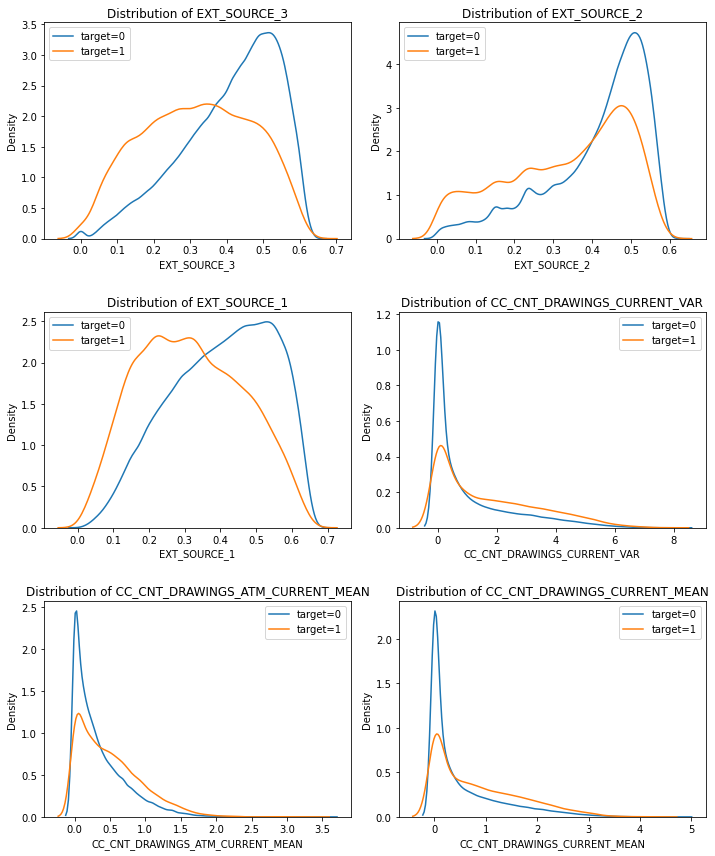

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

var = pd.concat([train_df, train_target], axis=1)
plt.figure(figsize=(10, 12))

# iterate through the sources
for i, source in enumerate(features_to_log):
    # create a new subplot for each source
    plt.subplot(3, 2, i + 1)
    # plot repaid loans
    sns.kdeplot(var.loc[var['TARGET'] == 0, source], label='target=0')
    # plot loans that were not repaid
    sns.kdeplot(var.loc[var['TARGET'] == 1, source], label='target=1')

    # Label the plots
    plt.title('Distribution of %s' % source)
    plt.xlabel('%s' % source)
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout(h_pad=2.5)

**IV. Hyperopt bayesian optimization for hyperparameters**

In [55]:
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix
from hyperopt import STATUS_OK
import shap


def calculate_f1(train_target, pred_array):
    # Define a formula that evaluates the results

    precision, recall, thresholds = precision_recall_curve(
        train_target, pred_array)
    fscore = (2 * precision * recall) / (precision + recall)

    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    print(confusion_matrix(train_target, np.round(pred_array)))

    return 'fscore', fscore[ix], True


def calculate_recall(train_target, pred_array):
    # convert probability (y=1) to label with threshold 0.5
    y_pred = np.round(pred_array)

    c_matrix = confusion_matrix(train_target, y_pred)
    TN = c_matrix[0, 0]
    FN = c_matrix[1, 0]
    FP = c_matrix[0, 1]
    TP = c_matrix[1, 1]
    recall = TP / (TP + FN)
    #recall_test = sklearn.metrics.recall_score(y_true, y_pred)
    return 'recall', recall, True


def bayesian_optimizer(space_params):
    """Function to optimize hyperparameter of the LightGBM Classifier with a Bayesian approach.
    In output we collect some metrics as F1score, precision, recall and confusion_matrix"""

    # Declare variables to store essential outputs of the function
    pred_array = np.zeros(train_df.shape[0])
    y_test_array = np.zeros(train_df.shape[0])
    metrics_results = dict()
    skf = StratifiedKFold(n_splits=5)

    shap_values = list()
    shap_expect_values = list()
    tested_values = list()

    # Go into the for loop and cross validation in 5 folds
    for i, (train_idx,
            test_idx) in enumerate(skf.split(train_df, train_target)):
        X_train, y_train = train_df.iloc[train_idx], train_target.iloc[
            train_idx]
        X_test, y_test = train_df.iloc[test_idx], train_target.iloc[test_idx]

        # Instanciate the LightGBM Classifier
        model = LGBMClassifier(**space_params)

        # And fit with training datas
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_train, y_train), (X_test, y_test)],
                  eval_metric=calculate_f1,
                  verbose=500,
                  early_stopping_rounds=100)

        # Record the shap values to plot some graphs later
        explainer = shap.TreeExplainer(model)
        shap_values.append(explainer.shap_values(X_test))
        shap_expect_values.append(explainer.expected_value)
        tested_values.append(X_test)

        # Record the predictions done with testing datas
        pred_array[test_idx] = model.predict_proba(
            X_test, num_iteration=int(model.best_iteration_))[:, 1]
        y_test_array[test_idx] = y_test

    # Record all the metrics in the metrics_result dictionnary
    metrics_results['precision'], metrics_results['recall'], metrics_results[
        'thresholds'] = precision_recall_curve(train_target, pred_array)
    metrics_results['auc'] = roc_auc_score(train_target, pred_array)
    """metrics_results['f1_score'] = f1_score(train_target, pred_array)
    metrics_results['precision_score'] = precision_score(
        train_target, pred_array)
    metrics_results['recall'] = recall_score(train_target, pred_array)
    metrics_results['confusion_matrix'] = confusion_matrix(
        train_target, pred_array).ravel()  # Return (tn, fp, fn, tp)"""
    metrics_results['ft_importances'] = model.feature_importances_
    metrics_results['pred_array'] = pred_array
    metrics_results['shap_values'] = shap_values
    metrics_results['shap_expect_values'] = shap_expect_values
    metrics_results['tested_values'] = tested_values
    metrics_results['y_test'] = y_test_array

    print('******************************************************************')
    print('Model trained and predictions done with AUC: ',
          metrics_results['auc'])
    print('******************************************************************')
    print(model.get_params())

    return metrics_results


def function_to_optimize(space_params):
    metrics = bayesian_optimizer(space_params)
    loss = -metrics['auc']

    precision = metrics['precision']
    recall = metrics['recall']
    thresholds = metrics['thresholds']
    testy = metrics['y_test']

    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    return {'loss': -fscore[ix], 'status': STATUS_OK}

In [68]:
from hyperopt import Trials, hp, tpe, fmin, space_eval, STATUS_OK
from hyperopt.pyll import scope

space_params = {
    #'is_unbalance': hp.choice('is_unbalance', ['true', 'false']),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.1, 0.3),
    'n_estimators':
    hp.choice('n_estimators', np.arange(100, 500, 100)),  # go for int values
    'learning_rate':
    hp.uniform('learning_rate', 0.001, 0.2),
    'num_leaves':
    hp.choice('num_leaves', np.arange(30, 150, 1)),
    'colsample_bytree':
    hp.uniform('colsample_bytree', 0.1, 1.2),
    'subsample':
    hp.uniform('subsample', 0.1, 1.2),
    'max_depth':
    hp.choice('max_depth', np.arange(2, 10, 1)), # go for int values
    'reg_alpha':
    hp.uniform('reg_alpha', 0.001, 0.2),
    'reg_lambda':
    hp.uniform('reg_lambda', 0.001, 0.2),
    'min_split_gain':
    hp.uniform('min_split_gain', 0.001, 0.2),
    'min_child_weight':
    hp.uniform('min_child_weight', 10, 70)
}

trials = Trials()

best_params = fmin(fn=function_to_optimize,
                   space=space_params,
                   algo=tpe.suggest,
                   max_evals=1,
                   trials=trials,
                   verbose=1)

print('******************************************************************')
print('Best parameters with bayesian optimization are :', '\n')
print(best_params)
print('******************************************************************')

Best Threshold=0.076172, F-Score=0.214               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.075883, F-Score=0.208               
[[56537     0]                                       
 [ 4965     0]]
Training until validation scores don't improve for 100 rounds
Best Threshold=0.072564, F-Score=0.268               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.072248, F-Score=0.254               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.068970, F-Score=0.294               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.090068, F-Score=nan                 
  0%|          | 0/1 [00:31<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.065412, F-Score=0.295               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.093627, F-Score=nan                 
  0%|          | 0/1 [00:32<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.062873, F-Score=0.298               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.062593, F-Score=0.282               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.059828, F-Score=0.296               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.059787, F-Score=0.278               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.057456, F-Score=0.301               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.096798, F-Score=nan                 
  0%|          | 0/1 [00:37<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.055048, F-Score=0.302               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.054279, F-Score=0.281               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.053039, F-Score=0.302               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.100699, F-Score=nan                 
  0%|          | 0/1 [00:39<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.051124, F-Score=0.301               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.100401, F-Score=nan                 
  0%|          | 0/1 [00:40<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.049707, F-Score=0.301               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.048467, F-Score=0.284               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.047058, F-Score=0.302               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.102276, F-Score=nan                 
  0%|          | 0/1 [00:43<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.045834, F-Score=0.302               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.101477, F-Score=nan                 
  0%|          | 0/1 [00:44<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.044071, F-Score=0.307               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.109784, F-Score=nan                 
  0%|          | 0/1 [00:45<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.043838, F-Score=0.307               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.109240, F-Score=nan                 
  0%|          | 0/1 [00:46<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.042958, F-Score=0.309               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.112962, F-Score=nan                 
  0%|          | 0/1 [00:47<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.041951, F-Score=0.309               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.122163, F-Score=nan                 
  0%|          | 0/1 [00:48<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.040561, F-Score=0.310               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.127603, F-Score=nan                 
  0%|          | 0/1 [00:50<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.040715, F-Score=0.317               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.136259, F-Score=nan                 
  0%|          | 0/1 [00:51<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.040228, F-Score=0.318               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.143468, F-Score=nan                 
  0%|          | 0/1 [00:52<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.039351, F-Score=0.322               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.145702, F-Score=nan                 
  0%|          | 0/1 [00:53<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.039374, F-Score=0.326               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.153459, F-Score=nan                 
  0%|          | 0/1 [00:54<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.037901, F-Score=0.325               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.156747, F-Score=nan                 
  0%|          | 0/1 [00:55<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.039548, F-Score=0.328               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.035787, F-Score=0.307               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.039211, F-Score=0.329               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.036019, F-Score=0.309               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.037768, F-Score=0.332               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.035097, F-Score=0.310               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.036647, F-Score=0.334               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.034571, F-Score=0.311               


invalid value encountered in true_divide



[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.036651, F-Score=0.336               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.034255, F-Score=0.314               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.038344, F-Score=0.338               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.034380, F-Score=0.316               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.036552, F-Score=0.340               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.034183, F-Score=0.316               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.035901, F-Score=0.341               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.034663, F-Score=0.317               


Best Threshold=0.033221, F-Score=0.329               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.041005, F-Score=0.364               
[[226145      0]                                     
 [ 19858      2]]
Best Threshold=0.035988, F-Score=0.329               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.041092, F-Score=0.365               
[[226145      0]                                     
 [ 19858      2]]
Best Threshold=0.033047, F-Score=0.329               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.041135, F-Score=0.366               
[[226145      0]                                     
 [ 19858      2]]
Best Threshold=0.033457, F-Score=0.330               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.041337, F-Score=0.367               
[[226145      0]                                     
 [ 19858      2]]


[[226145      0]                                     
 [ 19852      8]]
Best Threshold=0.038876, F-Score=0.338               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.048261, F-Score=0.385               
[[226145      0]                                     
 [ 19852      8]]
Best Threshold=0.038306, F-Score=0.338               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.046439, F-Score=0.386               
[[226145      0]                                     
 [ 19851      9]]
Best Threshold=0.038958, F-Score=0.338               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.045516, F-Score=0.387               
[[226145      0]                                     
 [ 19853      7]]
Best Threshold=0.038504, F-Score=0.338               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.045811, F-Score=0.388               


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



Best Threshold=0.076292, F-Score=0.225               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.076037, F-Score=0.206               
[[56537     0]                                       
 [ 4965     0]]
Training until validation scores don't improve for 100 rounds
Best Threshold=0.072622, F-Score=0.268               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.072517, F-Score=0.250               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.069039, F-Score=0.276               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.068091, F-Score=0.250               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.065846, F-Score=0.286               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.065901, F-Score=0.266               
[[56537 

Best Threshold=0.035615, F-Score=0.307               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.036460, F-Score=0.342               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.037039, F-Score=0.307               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.036190, F-Score=0.342               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.037063, F-Score=0.308               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.036253, F-Score=0.344               
[[226145      0]                                     
 [ 19860      0]]
Best Threshold=0.037209, F-Score=0.308               
[[56537     0]                                       
 [ 4965     0]]
Best Threshold=0.035558, F-Score=0.345               
[[226145      0]                                     
 [ 19860      0]]


[[226145      0]                                     
 [ 19858      2]]
Best Threshold=0.038822, F-Score=0.322               
[[56537     0]                                       
 [ 4964     1]]
Best Threshold=0.040245, F-Score=0.369               
[[226145      0]                                     
 [ 19858      2]]
Best Threshold=0.038966, F-Score=0.321               
[[56537     0]                                       
 [ 4964     1]]
Best Threshold=0.040351, F-Score=0.370               
[[226145      0]                                     
 [ 19858      2]]
Best Threshold=0.038548, F-Score=0.321               
[[56537     0]                                       
 [ 4964     1]]
Best Threshold=0.040179, F-Score=0.371               
[[226145      0]                                     
 [ 19858      2]]
Best Threshold=0.036629, F-Score=0.323               
[[56537     0]                                       
 [ 4964     1]]
Best Threshold=0.040396, F-Score=0.372               


Best Threshold=0.044723, F-Score=0.388               
[[226145      0]                                     
 [ 19845     15]]
Best Threshold=0.041464, F-Score=0.330               
[[56536     1]                                       
 [ 4962     3]]
Best Threshold=0.044554, F-Score=0.389               
[[226145      0]                                     
 [ 19843     17]]
Best Threshold=0.041533, F-Score=0.330               
[[56536     1]                                       
 [ 4962     3]]
Did not meet early stopping. Best iteration is:      
[100]	training's binary_logloss: 0.276627	training's fscore: 0.388966	valid_1's binary_logloss: 0.290418	valid_1's fscore: 0.330128
  0%|          | 0/1 [04:55<?, ?trial/s, best loss=?]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



Best Threshold=0.076371, F-Score=0.222               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.076172, F-Score=0.210               
[[56536     0]                                       
 [ 4965     0]]
Training until validation scores don't improve for 100 rounds
Best Threshold=0.072234, F-Score=0.244               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.071652, F-Score=0.223               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.068656, F-Score=0.256               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.088859, F-Score=nan                 
  0%|          | 0/1 [05:32<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.065344, F-Score=0.282               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.065402, F-Score=0.251               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.062172, F-Score=0.282               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.062250, F-Score=0.250               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.060727, F-Score=0.307               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.105864, F-Score=nan                 
  0%|          | 0/1 [05:35<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.058192, F-Score=0.308               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.113050, F-Score=nan                 
  0%|          | 0/1 [05:36<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.055528, F-Score=0.308               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.054945, F-Score=0.278               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.054307, F-Score=0.314               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.052834, F-Score=0.283               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.052279, F-Score=0.317               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.051105, F-Score=0.286               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.051090, F-Score=0.320               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.050041, F-Score=0.290               


invalid value encountered in true_divide



[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.047425, F-Score=0.322               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.131128, F-Score=nan                 
  0%|          | 0/1 [05:43<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.047144, F-Score=0.322               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.044209, F-Score=0.290               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.045514, F-Score=0.324               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.044019, F-Score=0.292               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.043462, F-Score=0.324               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.042282, F-Score=0.290               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.043435, F-Score=0.327               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.043015, F-Score=0.293               


Best Threshold=0.035897, F-Score=0.318               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.039616, F-Score=0.357               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.034002, F-Score=0.318               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.040107, F-Score=0.357               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.033060, F-Score=0.318               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.040203, F-Score=0.358               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.031954, F-Score=0.319               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.040119, F-Score=0.359               
[[226146      0]                                     
 [ 19860      0]]


[[226146      0]                                     
 [ 19857      3]]
Best Threshold=0.039265, F-Score=0.327               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.043913, F-Score=0.381               
[[226146      0]                                     
 [ 19856      4]]
Best Threshold=0.037419, F-Score=0.328               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.045043, F-Score=0.381               
[[226146      0]                                     
 [ 19856      4]]
Best Threshold=0.038545, F-Score=0.329               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.043978, F-Score=0.382               
[[226146      0]                                     
 [ 19855      5]]
Best Threshold=0.038453, F-Score=0.328               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.045045, F-Score=0.382               


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



Best Threshold=0.076214, F-Score=0.221               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.075910, F-Score=0.212               
[[56536     0]                                       
 [ 4965     0]]
Training until validation scores don't improve for 100 rounds
Best Threshold=0.071974, F-Score=0.242               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.071986, F-Score=0.226               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.068579, F-Score=0.255               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.068984, F-Score=0.241               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.065520, F-Score=0.282               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.065004, F-Score=0.264               
[[56536 

Best Threshold=0.039098, F-Score=0.317               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.037981, F-Score=0.346               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.038964, F-Score=0.319               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.037512, F-Score=0.347               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.038270, F-Score=0.317               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.037688, F-Score=0.348               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.040102, F-Score=0.317               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.038241, F-Score=0.349               
[[226146      0]                                     
 [ 19860      0]]


[[226146      0]                                     
 [ 19858      2]]
Best Threshold=0.041921, F-Score=0.328               
[[56536     0]                                       
 [ 4964     1]]
Best Threshold=0.042810, F-Score=0.370               
[[226146      0]                                     
 [ 19858      2]]
Best Threshold=0.042626, F-Score=0.328               
[[56536     0]                                       
 [ 4964     1]]
Best Threshold=0.042699, F-Score=0.371               
[[226146      0]                                     
 [ 19858      2]]
Best Threshold=0.041853, F-Score=0.328               
[[56536     0]                                       
 [ 4964     1]]
Best Threshold=0.042612, F-Score=0.371               
[[226146      0]                                     
 [ 19857      3]]
Best Threshold=0.039415, F-Score=0.328               
[[56536     0]                                       
 [ 4964     1]]
Best Threshold=0.042184, F-Score=0.372               


Best Threshold=0.047688, F-Score=0.389               
[[226146      0]                                     
 [ 19844     16]]
Best Threshold=0.042202, F-Score=0.335               
[[56536     0]                                       
 [ 4963     2]]
Best Threshold=0.047165, F-Score=0.389               
[[226146      0]                                     
 [ 19844     16]]
Best Threshold=0.041222, F-Score=0.335               
[[56536     0]                                       
 [ 4962     3]]
Did not meet early stopping. Best iteration is:      
[100]	training's binary_logloss: 0.276701	training's fscore: 0.388865	valid_1's binary_logloss: 0.290056	valid_1's fscore: 0.335447
  0%|          | 0/1 [09:56<?, ?trial/s, best loss=?]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



Best Threshold=0.076251, F-Score=0.224               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.076251, F-Score=0.217               
[[56536     0]                                       
 [ 4965     0]]
Training until validation scores don't improve for 100 rounds
Best Threshold=0.072155, F-Score=0.240               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.072028, F-Score=0.229               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.068708, F-Score=0.250               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.087668, F-Score=nan                 
  0%|          | 0/1 [10:33<?, ?trial/s, best loss=?]

invalid value encountered in true_divide



[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.065416, F-Score=0.279               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.065658, F-Score=0.267               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.062290, F-Score=0.278               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.061790, F-Score=0.268               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.060527, F-Score=0.302               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.060094, F-Score=0.292               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.058219, F-Score=0.303               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.056966, F-Score=0.289               


Best Threshold=0.035911, F-Score=0.323               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.037123, F-Score=0.346               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.036046, F-Score=0.323               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.036632, F-Score=0.347               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.035598, F-Score=0.323               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.036325, F-Score=0.349               
[[226146      0]                                     
 [ 19860      0]]
Best Threshold=0.036394, F-Score=0.323               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.036396, F-Score=0.350               
[[226146      0]                                     
 [ 19860      0]]


[[226146      0]                                     
 [ 19857      3]]
Best Threshold=0.036929, F-Score=0.333               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.039541, F-Score=0.370               
[[226146      0]                                     
 [ 19857      3]]
Best Threshold=0.036973, F-Score=0.334               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.039633, F-Score=0.372               
[[226146      0]                                     
 [ 19856      4]]
Best Threshold=0.037199, F-Score=0.333               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.039989, F-Score=0.372               
[[226146      0]                                     
 [ 19856      4]]
Best Threshold=0.037522, F-Score=0.333               
[[56536     0]                                       
 [ 4965     0]]
Best Threshold=0.039716, F-Score=0.373               


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



******************************************************************
Model trained and predictions done with AUC:         
0.7818121185397421                                   
******************************************************************
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.21785332517206019, 'importance_type': 'split', 'learning_rate': 0.087013677752215, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 21.178799387963174, 'min_split_gain': 0.12666699291226666, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 48, 'objective': None, 'random_state': None, 'reg_alpha': 0.12331923436831409, 'reg_lambda': 0.030609985574373475, 'silent': True, 'subsample': 0.475960283786765, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'scale_pos_weight': 0.22521810253233435}
100%|██████████| 1/1 [12:48<00:00, 768.49s/trial, best loss: -0.332505195393678]
******************************************************************
Best parameters with bayesian opti

**V. Initiate the model**

In [17]:
metrics = bayesian_optimizer(best_params)

TypeError: fit() got an unexpected keyword argument 'feval'

Best Threshold=0.075362, F-Score=0.233


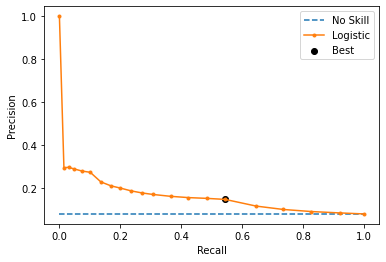

In [10]:
import matplotlib.pyplot as plt

precision = metrics['precision']
recall = metrics['recall']
thresholds = metrics['thresholds']
testy = metrics['y_test']

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))


# plot the PR curve for the model
no_skill = len(testy[testy==1]) / len(testy)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [14]:
recall

array([1.        , 0.92040282, 0.82787513, 0.73619335, 0.64644512,
       0.54441088, 0.4844713 , 0.42392749, 0.36559919, 0.30662638,
       0.27162135, 0.23609265, 0.20008056, 0.16962739, 0.13591138,
       0.10134945, 0.07440081, 0.04946626, 0.02992951, 0.01478348,
       0.        ])

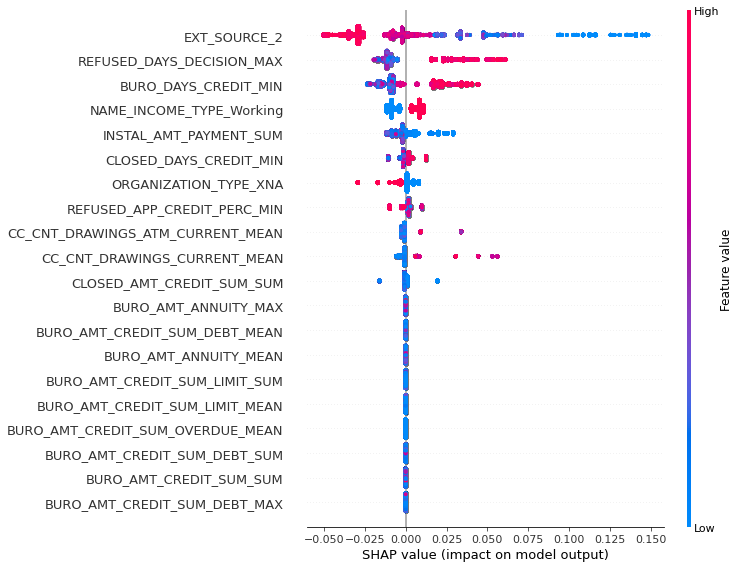

In [13]:
shap.summary_plot(metrics['shap_values'][0][1], metrics['tested_values'][0])

In [14]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(metrics['shap_expect_values'][3][0],
                 metrics['shap_values'][3][0][4, :], 
                 metrics['tested_values'][3].iloc[4])

In [15]:
# Modifier le space param pour ne plus a galerer avec les int de max depth et n_estim
# Utilisation de scope.int()

# Définir la fonction coût métier en restant sur la fonction predict proba de mon modèle

